<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_itabuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 em Itabuna/BA
**Fonte**: https://www.facebook.com/PrefeituradeItabuna/  
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/itabuna.csv   
**Github**: https://github.com/covidba/covid

In [0]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np

data_atual = date.today().strftime("%d-%m-%Y")
cidade = 'Itabuna'
cidade_file_name = 'itabuna'
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes', 'tendencia'], parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Expectativa']

#set date as index
lista_data = df['data']
df.set_index('data', inplace=True)
df.tail(20)

,Casos confirmados,Casos recuperados,Mortes,Expectativa
data,,,,
2020-05-13,436.0,107.0,12.0,442.482071
2020-05-14,484.0,110.0,15.0,469.681870
2020-05-15,510.0,113.0,15.0,498.216016
2020-05-16,564.0,118.0,15.0,528.148345
2020-05-17,580.0,119.0,15.0,559.546503
2020-05-18,588.0,161.0,20.0,592.480912
2020-05-19,608.0,161.0,22.0,627.024687
2020-05-20,624.0,170.0,24.0,663.255051
2020-05-21,672.0,175.0,25.0,701.252694


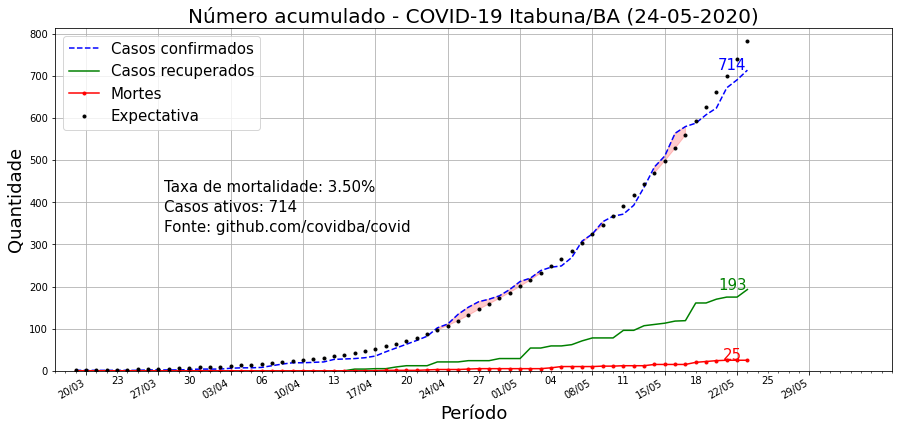

In [0]:
from matplotlib.dates import MO

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(df['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color):
  ax.annotate(int(df[caso].max()), xy=(lista_data[ultimo_caso_valido_id], df[caso].max()), 
              xycoords='data', ha='center', fontsize=15, color=color,
              xytext=(-15, 0), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

taxa_mortalidade = (100 * df['Mortes'].max()) / df['Casos confirmados'].max()
ax.annotate('Taxa de mortalidade: %.2f%%' % taxa_mortalidade , xy=(lista_data.min() + timedelta(days=10), df['Casos confirmados'].max()/2+20), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(-15, 20), textcoords='offset points')
casos_ativos = int(df['Casos confirmados'].max() - df['Casos recuperados'].min())
ax.annotate('Casos ativos: %s' % casos_ativos , xy=(lista_data.min() + timedelta(days=10), df['Casos confirmados'].max()/2+20), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(-15, 0), textcoords='offset points')

url_expectativa = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_expectativa , xy=(lista_data.min() + timedelta(days=10), df['Casos confirmados'].max()/2+20), 
            xycoords='data', ha='left', fontsize=15, color='black',
            xytext=(-15, -20), textcoords='offset points')

ax.fill_between(df.index, df['Casos confirmados'], df['Expectativa'], 
                where=df['Casos confirmados']>=df['Expectativa'], alpha=0.2, color='red')

ax.set_ylim(0, df['Casos confirmados'].max() + 100)
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max() + timedelta(days=5)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

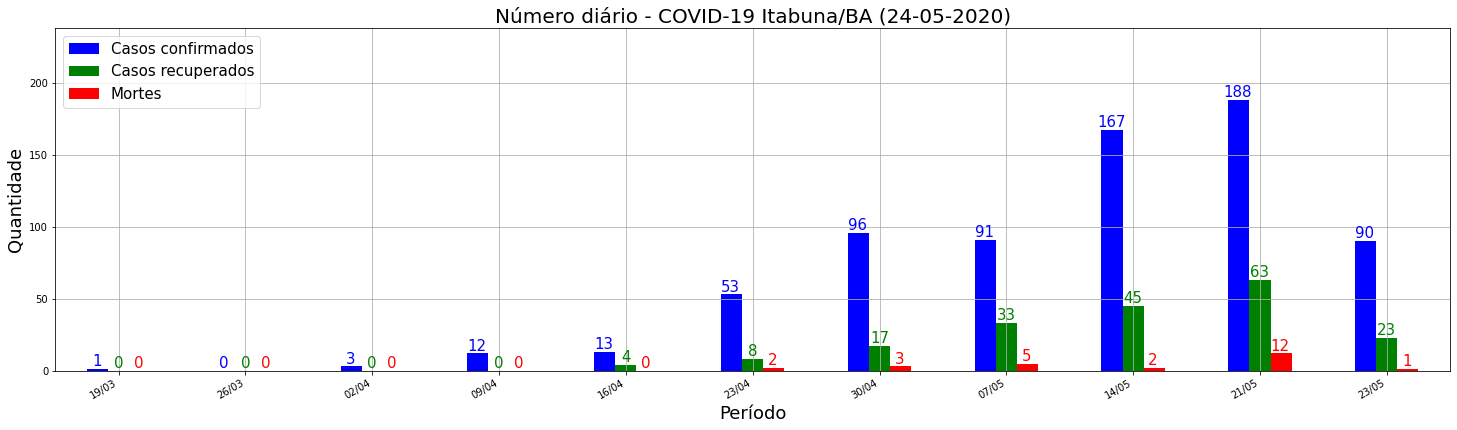

In [0]:
frequencia = 7

dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []

def alimentar_lista(lista, texto):
  for id, v in enumerate(df[texto]):
    if not pd.isnull(v):
      if(id) == 0:
        lista.append(v)  
      else:
        lista.append(v - df[texto][id-1])

alimentar_lista(casos_confirmados_diaria, 'Casos confirmados')
alimentar_lista(casos_recuperados_diaria, 'Casos recuperados')
alimentar_lista(casos_mortes_diaria, 'Mortes')

def alimentar_dict(lista, texto):
  soma_casos = 0
  for id, v in enumerate(lista):
    if not pd.isnull(v):
      if id % frequencia == 0:
        if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
        if id == 0:
          dict_diaria[texto].append(v)
        else:
          dict_diaria[texto].append(soma_casos)
          soma_casos = v
      else:
        soma_casos += v
        if(len(lista)-1 == id):
          dict_diaria[texto].append(soma_casos)
          if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])

alimentar_dict(casos_confirmados_diaria, 'confirmados_diaria')
alimentar_dict(casos_recuperados_diaria, 'recuperados_diaria')
alimentar_dict(casos_mortes_diaria, 'mortes_diaria')

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes']
novo_df = df_diaria
df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(25,7))
df_diaria.plot(ax=ax, color=colors, kind='bar')
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x):
  for i, v in enumerate(df_diaria[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')

plotar_valores('Casos confirmados', 'b', -22)
plotar_valores('Casos recuperados', 'g', 0)
plotar_valores('Mortes', 'r', 20)

def plotar_dados(texto, x, y):
  ax.annotate(texto , xy=(df['Mortes'][4], df['Casos confirmados'][len(df['Casos confirmados'])-1]), 
              xycoords='data', ha='left', fontsize=15, color='black', 
              xytext=(x, df['Casos confirmados'][len(df['Casos confirmados'])-1]-y), textcoords='offset points')

plotar_dados('Casos ativos: %s' % casos_ativos, 40, 40)
plotar_dados('Taxa de mortalidade: %.2f%%' % taxa_mortalidade, 40, 60)
plotar_dados('Fonte: %s' % url_expectativa, 40, 80)

ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 50])
ax.set_title("Número diário - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

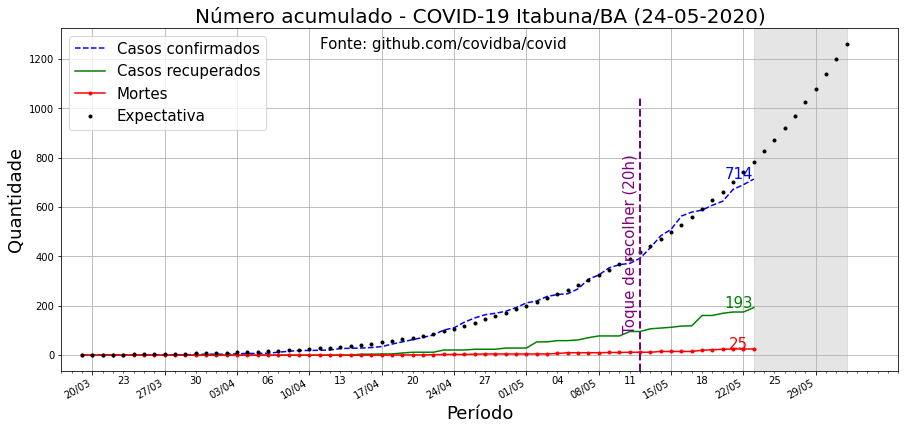

In [30]:
df1 = pd.read_csv(url, usecols=['data', 'restricao'], parse_dates=['data'])
df1.columns = ['data', 'Medida Restritiva']

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df1['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), df1['data'][len(lista_data)-1].strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()], ymax=0.8)
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df1['data'][id])).argmax()], 100), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
def adicionar_medidas():
  for id, medida in enumerate(df1['Medida Restritiva']):
    # toque de recolher
    if not pd.isnull(medida):
      if medida == 0:
        adicionar_medida('Comércio aberto', id) 
      elif medida == 1:
        adicionar_medida('Comércio fechado', id, color='purple') 
      elif medida > 1:
        if medida == 24:
          adicionar_medida('Saída do toque de recolher', id)
        else:
          adicionar_medida('Toque de recolher (%sh)' % int(medida), id, color='purple')      
      elif medida == -1:
        adicionar_medida('Entrada no lockdown', id, color='purple')
      elif str(medida) == '-0':
        adicionar_medida('Saída do lockdown', id)
  
adicionar_medidas()

# ADICIONAR VALORES  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.annotate('Fonte: %s' % url_expectativa , xy=(df1['data'].min()+timedelta(days=35), df['Expectativa'].max()-20), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max() + timedelta(days=5)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

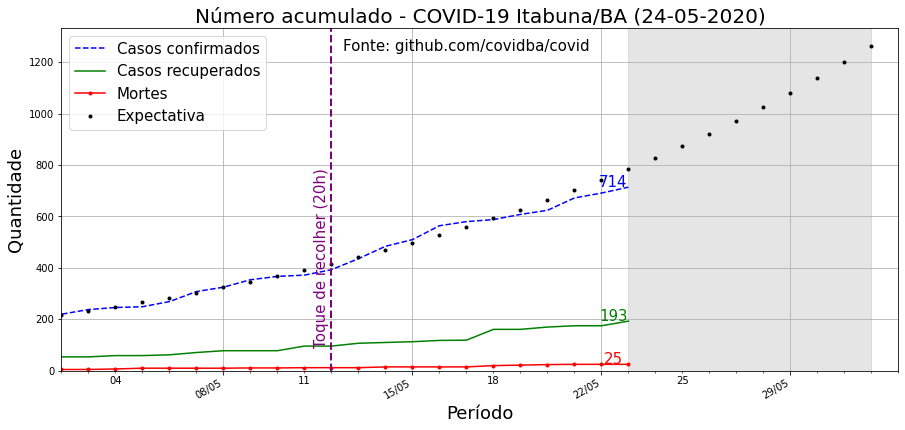

In [27]:
df1 = pd.read_csv(url, usecols=['data', 'restricao'], parse_dates=['data'])
df1.columns = ['data', 'Medida Restritiva']

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black']
ls = ['--', '-', '.-', '.']
df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df1['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), df1['data'][len(lista_data)-1].strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

adicionar_medidas()

# ADICIONAR VALORES
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')

ax.annotate('Fonte: %s' % url_expectativa , xy=(df1['data'].max()-timedelta(days=15), df['Expectativa'].max()-20), 
            xycoords='data', ha='center', fontsize=15, color='black', xytext=(0, 0), textcoords='offset points')

ax.set_ylim([0, df['Expectativa'].max() + 70])
ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max() + timedelta(days=1)])
ax.set_title("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)